<html>
<div>
  <img src="https://www.engineersgarage.com/wp-content/uploads/2021/11/TCH36-01-scaled.jpg" width=360px width=auto style="vertical-align: middle;">
  <span style="font-family: Georgia; font-size:30px; color: white;"> <br/> University of Tehran <br/> AI_CA6 <br/> Spring 02 </span>
</div>
<span style="font-family: Georgia; font-size:15pt; color: white; vertical-align: middle;"> low_mist - std id: 810100186 </span>
</html>

In this notebook we are implement and train a neural network to classify texts.

## Problem Description
in this problem we will learn basics of `Neural Network`. for Part. 1 we train a model for a dataset and classify them and then we pytorch to train a model to help us classifying texts based on their sentiments from a dataset that contains reviews of people about movies.

In [1000]:
from __future__ import annotations

# data manipulation
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from abc import ABC, abstractmethod
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px


# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_moons
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split

# text processing
import re
import nltk as nlt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# types
from dataclasses import dataclass
from enum import Enum
from typing import Union, Iterable, Callable, Optional
from collections import namedtuple, Counter

# tensorflow
import tensorflow as tf
from tensorflow import keras

## torch
import torch
from torch import nn
from torch.nn import ReLU, Sigmoid, Linear
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import grad

# utils
import os
from tqdm import tqdm

In [1001]:
# nlt.download('stopwords')
# nlt.download('wordnet')
# nlt.download('punkt')

stopwords = set(stopwords.words('english'))

## Part 1. MLP from scratch

We will code a [FNN](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiq2ue-qJP_AhVJgP0HHdbtCk8QFnoECAoQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FFeedforward_neural_network&usg=AOvVaw3rDG-BPMXT8xxLxhU6yJlG) (i.e. Feed Forward Neural Network) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check out `torch.clamp`, `torch.nn.Parameter`


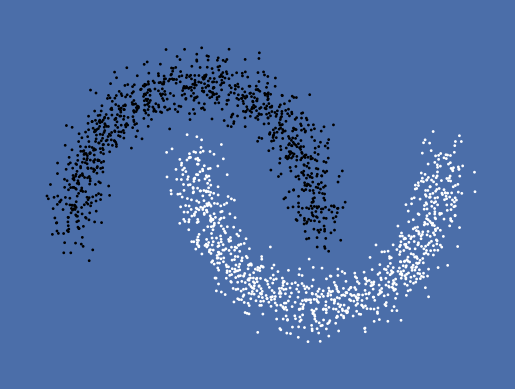

In [1002]:
X, Y = make_moons(n_samples=2000, noise=0.1)

x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

def plot_data(ax: Axes, X: NDArray, Y: NDArray):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

%matplotlib inline
plot_data(ax, X, Y)
plt.show()


In [1003]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

def plot_decision_boundary(ax: Axes, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)

    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z > 0.5, cmap="Blues")

    plot_data(ax, X, Y)

Implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation.

## ReLU (Rectified Linear Unit)

The ReLU activation function is defined as:

$$
f(x) = max(0, x)
$$

where $x$ is the input to the function.

### Forward Pass

During the forward pass, the ReLU function simply returns the input value if it is positive, and returns 0 if it is negative. Mathematically, this can be expressed as:

$$
f(x) = \begin{cases}
x & \text{if } x > 0 \\
0 & \text{otherwise}
\end{cases}
$$

### Backward Pass

During the backward pass, the gradient of the loss function with respect to the input is computed using the chain rule. If the input is positive, the gradient is simply 1, since the output of the ReLU function is equal to the input. If the input is negative, the gradient is 0, since the output of the ReLU function is 0. Mathematically, this can be expressed as:

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial x} 
= \begin{cases}
\frac{\partial L}{\partial x} & \text{ if } x > 0 \\ 
0 & \text{otherwise}
\end{cases}
$$

where $\frac{\partial L}{\partial x}$ is the gradient of the loss function with respect to the input, $\frac{\partial L}{\partial f}$ is the gradient of the loss function with respect to the output of the ReLU function, and $\frac{\partial f}{\partial x}$ is the derivative of the ReLU function with respect to the input.

## Sigmoid

The sigmoid activation function is defined as:

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

where $x$ is the input to the function and $e$ is the exponential function.

### Forward Pass

During the forward pass, the sigmoid function returns a value between 0 and 1 for any input. Mathematically, this can be expressed as:

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

### Backward Pass

During the backward pass, the gradient of the loss function with respect to the input is computed using the chain rule. The gradient of the sigmoid function with respect to the input is given by:

$$
\frac{\partial f}{\partial x} = f(x) (1 - f(x))
$$

where $f(x)$ is the output of the function. The gradient of the loss function with respect to the output of the sigmoid function is then multiplied by the gradient of the sigmoid function with respect to the input to obtain the gradient of the loss function with respect to the input. Mathematically, this can be expressed as:

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial x} = \frac{\partial L}{\partial f} f(x) (1 - f(x))
$$

where $\frac{\partial L}{\partial x}$ is the gradient of the loss function with respect to the input, $\frac{\partial L}{\partial f}$ is the gradient of the loss function with respect to the output of the sigmoid function, and $\frac{\partial f}{\partial x}$ is the derivative of the sigmoid function with respect to the input.

In [1004]:
class MyReLU(object):
    def __init__(self):
        self.input_x = None

    def forward(self, x) -> NDArray:
        # The ReLU is y_i = max(0, x_i)
        self.input_x = x
        return np.maximum(0, x)

    def backward(self, grad_output) -> NDArray:
        # The gradient is 1 for the inputs that were above 0, 0 elsewhere
        if self.input_x is None:
            raise ValueError("Forward pass must be called before backward pass.")
        grad_input = grad_output.copy()
        grad_input[self.input_x <= 0] = 0
        return grad_input

    def step(self, learning_rate):
        # No need to do anything here, since ReLU has no parameters
        pass


class MySigmoid(object):
    def forward(self, x) -> NDArray:
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        x = np.clip(x, -100, 100)
        return 1. / (1. + np.exp(-x))

    
    def backward(self, grad_output) -> NDArray:
        # the partial derivative is e^-x / (e^-x + 1)^2
        # sigmoid = self.forward(grad_output)
        sigmoid = self.forward(grad_output)
        return grad_output * sigmoid * (1 - sigmoid)
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        pass


In [1005]:
x = np.array([0, -1, 0.5, -0.5, 0.8, 1])
grad_output = np.ones_like(x)
x_torch = torch.tensor(x, requires_grad=True)
grad_output_torch = torch.tensor(grad_output)

my_relu = MyReLU()

torch_relu = ReLU()

my_relu_output = my_relu.forward(x)
my_relu_grad_input = my_relu.backward(grad_output)

torch_relu_output = torch_relu(x_torch)
torch_relu_output.backward(grad_output_torch)
torch_relu_grad_input = x_torch.grad.numpy()

print("MyReLU grad_input:", my_relu_grad_input)
print("PyTorch ReLU grad_input:", torch_relu_grad_input)
print("MyReLU output:", my_relu_output)
print("PyTorch ReLU output:", torch_relu_output)

MyReLU grad_input: [0. 0. 1. 0. 1. 1.]
PyTorch ReLU grad_input: [0. 0. 1. 0. 1. 1.]
MyReLU output: [0.  0.  0.5 0.  0.8 1. ]
PyTorch ReLU output: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.8000, 1.0000], dtype=torch.float64,
       grad_fn=<ReluBackward0>)


In [1006]:
my_sigmoid = MySigmoid()
torch_sigmoid = Sigmoid()

my_sigmoid_output = my_sigmoid.forward(x)
my_sigmoid_grad_input = my_sigmoid.backward(grad_output)

torch_sigmoid_output = torch_sigmoid(x_torch)
torch_sigmoid_output.backward(grad_output_torch)
torch_sigmoid_grad_input = x_torch.grad.numpy()

print("MySigmoid output:", my_sigmoid_output)
print("PyTorch Sigmoid output:", torch_sigmoid_output)
print("MySigmoid grad_input:", my_sigmoid_grad_input)
print("PyTorch Sigmoid grad_input:", torch_sigmoid_grad_input)


MySigmoid output: [0.5        0.26894142 0.62245933 0.37754067 0.68997448 0.73105858]
PyTorch Sigmoid output: tensor([0.5000, 0.2689, 0.6225, 0.3775, 0.6900, 0.7311], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)
MySigmoid grad_input: [0.19661193 0.19661193 0.19661193 0.19661193 0.19661193 0.19661193]
PyTorch Sigmoid grad_input: [0.25       0.19661193 1.23500371 0.23500371 1.2139097  1.19661193]


### Linear Layer

A linear layer, also known as a fully connected layer, is a type of layer in a neural network that connects every neuron in one layer to every neuron in the next layer. It is called a linear layer because it performs a linear transformation on the input data.

The linear layer can be represented mathematically as:

$$y = Wx + b$$

where $x$ is the input data, $W$ is the weight matrix, $b$ is the bias vector, and $y$ is the output of the linear layer.

During forward propagation, the input data is multiplied by the weight matrix and the bias vector is added to the result. The output of the linear layer is then passed through an activation function, such as ReLU or sigmoid, to introduce non-linearity into the network.

The weight matrix $W$ contains the learnable parameters of the layer, which are updated during training to minimize the loss function. The bias vector $b$ is added to the output of the weight matrix to introduce a shift in the output.

During backpropagation, the gradients of the loss function with respect to the weight matrix and bias vector are computed and used to update the parameters of the layer.

The linear layer is typically used in the early layers of a neural network, where the input data is transformed into a higher-dimensional space. This transformation allows the neural network to learn more complex features of the input data.


In [1007]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (np.random.randn)
        self.W = np.random.randn(n_input, n_output)
        self.b = np.random.randn(n_output)

    def forward(self, x: NDArray):
        # save a copy of x, you'll need it for the backward
        self.x = x
        # return Wx + b
        return np.dot(x, self.W) + self.b

    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        if self.x.ndim == 1:
            self.dW = np.outer(self.x, grad_output)
        else:
            self.dW = np.dot(self.x.T, grad_output)
        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        self.db = np.sum(grad_output, axis=0)
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        dx = np.dot(grad_output, self.W.T)
        # dx = grad_output @ self.W.T
        
        return dx
        
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db
        # b = self.b.copy()
        # W = self.W.copy()
        # W -= learning_rate * self.dW
        # b -= learning_rate * self.db

Now we test our class

In [1008]:
x = np.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0], [9.0, 10.0]])
grad_output = np.array([[1.0, 2.0, 3.0], [2.0, 5.0, 1.0], [6.0, 6.0, 9.0], [8.0, 7.0, 6.0], [4.0, 2.0, 1.0]])
my_linear = MyLinear(n_input=2, n_output=3)
torch_linear = Linear(in_features=2, out_features=3)

with torch.no_grad():
    torch_linear.weight.copy_(torch.tensor(my_linear.W.T))
    torch_linear.bias.copy_(torch.tensor(my_linear.b))
    
x_torch = torch.tensor(x, requires_grad=True, dtype=torch_linear.weight.dtype)
grad_output_torch = torch.tensor(grad_output, dtype=torch_linear.weight.dtype)

my_linear_output = my_linear.forward(x)
my_linear_grad_input = my_linear.backward(grad_output)

torch_linear_output = torch_linear(x_torch)
torch_linear_output.backward(grad_output_torch)
torch_linear_grad_input = x_torch.grad.numpy()
torch_linear_dW = torch_linear.weight.grad.numpy().T
torch_linear_db = torch_linear.bias.grad.numpy()


print("MyLinear output:\n", my_linear_output)
print("PyTorch Linear output:\n", torch_linear_output)
print("MyLinear grad_input:\n", my_linear_grad_input)
print("PyTorch Linear grad_input:\n", torch_linear_grad_input)
print("MyLinear dW:\n", my_linear.dW)
print("PyTorch Linear dW:\n", torch_linear_dW)
print("MyLinear db:\n", my_linear.db)
print("PyTorch Linear db:\n", torch_linear_db)

MyLinear output:
 [[-0.37370979 -1.03922704  1.56375895]
 [-2.20345172 -3.14775218  5.99231989]
 [-4.03319365 -5.25627731 10.42088082]
 [-5.86293557 -7.36480245 14.84944176]
 [-7.6926775  -9.47332759 19.27800269]]
PyTorch Linear output:
 tensor([[-0.3737, -1.0392,  1.5638],
        [-2.2035, -3.1478,  5.9923],
        [-4.0332, -5.2563, 10.4209],
        [-5.8629, -7.3648, 14.8494],
        [-7.6927, -9.4733, 19.2780]], grad_fn=<AddmmBackward0>)
MyLinear grad_input:
 [[  6.41051519  -2.79106988]
 [  2.3343837   -7.221158  ]
 [ 18.56758906 -10.45386605]
 [ 11.8852474  -13.29837028]
 [  1.49961602  -5.05334455]]
PyTorch Linear grad_input:
 [[  6.410515   -2.7910697]
 [  2.3343837  -7.2211576]
 [ 18.567589  -10.453867 ]
 [ 11.885247  -13.298369 ]
 [  1.4996159  -5.0533442]]
MyLinear dW:
 [[129. 114. 102.]
 [150. 136. 122.]]
PyTorch Linear dW:
 [[129. 114. 102.]
 [150. 136. 122.]]
MyLinear db:
 [21. 22. 20.]
PyTorch Linear db:
 [21. 22. 20.]


Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [1009]:
class Sequential(object):
    def __init__(self):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        # YOUR CODE HERE
        eps = 1e-10
        if out == 1:
            out -= eps
        elif out == 0:
            out += eps
        loss = -(label * np.log(out) + (1 - label) * np.log(1 - out))
        self.grad_loss = -label / (out) + (1 - label) / (1 - out)
        return loss

    def backward(self):
        grad = self.grad_loss
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        for layer in self.layers:
            layer.step(learning_rate)

In [1010]:
my_model = Sequential()
my_model.add_layer(MyLinear(n_input=2, n_output=5))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=5, n_output=5))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=5, n_output=5))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=5, n_output=1))
my_model.add_layer(MySigmoid())


torch_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1),
    nn.Sigmoid(),
)

with torch.no_grad():
    for i in [0, 2, 4, 6]:
        my_linear_layer = my_model.layers[i]
        torch_linear_layer = torch_model[i]
        torch_linear_layer.weight.copy_(torch.tensor(my_linear_layer.W.T))
        torch_linear_layer.bias.copy_(torch.tensor(my_linear_layer.b))
    
    # weights = []
    # for w in torch_model[i].weight.T:
    #     weight = []
    #     for j in w:
    #         weight.append(j.item())
    #     weights.append(weight)
    # my_model.layers[i].W = np.array(weights)

    # bias = []
    # for b in torch_model[i].bias:
    #     bias.append(b.item())
    # my_model.layers[i].b = np.array(bias)
    

In [1011]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    epoch_loss = np.array([])
    for _ in range(len(X)):
        # pick a random example idx
        idx = np.random.randint(0, len(X))
        # select the corresponding example and label
        x = X[idx]
        y = Y[idx]
        # do a forward pass on the example
        out = my_model.forward(x)
        # compute the loss according to your output and the label
        loss = my_model.compute_loss(out, y)
        # epoch_loss = np.append(epoch_loss, loss)
        losses.append(loss[0])
        # backward pass
        my_model.backward()
        # gradient step
        my_model.step(learning_rate)
    # losses.append(np.mean(epoch_loss))

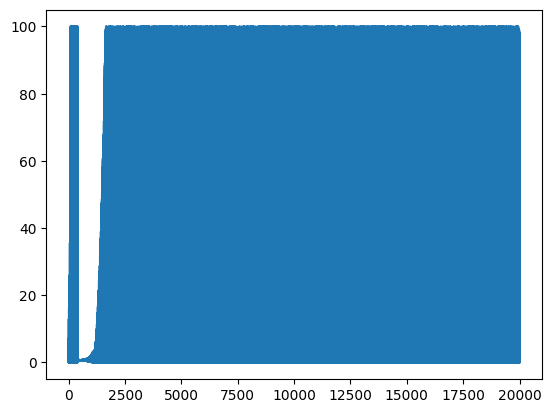

In [1012]:
%matplotlib inline
plt.plot(losses)
plt.show()

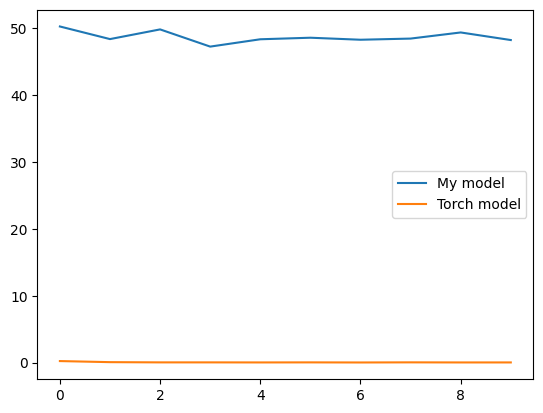

In [1013]:
loss_fn = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.SGD(torch_model.parameters(), lr=1e-2)

# Convert X and Y to torch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
Y_torch = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

my_losses = []
torch_losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    epoch_loss_my_model = np.array([])
    epoch_loss_torch_model = np.array([])
    for _ in range(len(X)):
        # pick a random example idx
        idx = np.random.randint(0, len(X))
        # select the corresponding example and label
        x = X[idx]
        y = Y[idx]
        x_torch = X_torch[idx]
        y_torch = Y_torch[idx]

        # do a forward pass on the example using my_model
        out_my_model = my_model.forward(x)
        # compute the loss according to your output and the label
        loss_my_model = my_model.compute_loss(out_my_model, y)
        epoch_loss_my_model = np.append(epoch_loss_my_model, loss_my_model)
        # backward pass
        my_model.backward()
        # gradient step
        my_model.step(learning_rate)

        # do a forward pass on the example using torch_model
        out_torch_model = torch_model(x_torch)
        # compute the loss according to your output and the label
        loss_torch_model = loss_fn(out_torch_model, y_torch)
        epoch_loss_torch_model = np.append(epoch_loss_torch_model, loss_torch_model.item())
        # backward pass
        optimizer.zero_grad()
        loss_torch_model.backward()
        # gradient step
        optimizer.step()

    my_losses.append(np.mean(epoch_loss_my_model))
    torch_losses.append(np.mean(epoch_loss_torch_model))

plt.plot(my_losses, label="My model")
plt.plot(torch_losses, label="Torch model")
plt.legend()
plt.show()

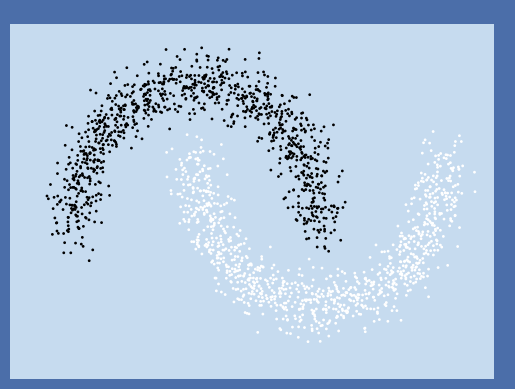

In [1014]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, my_model)
fig.canvas.draw()

## Part 2. Using a Pytorch module

In this last part, we use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

## Dataset
The `imdb_dataset.csv` file contains data about around 50000 people reviews from [imdb](https://imdb.com) and their sentiments. The dataset was gathered from [this link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [1015]:
df = pd.read_csv("assets/data/imdb_dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [1016]:
df.shape

(50000, 2)

In [1017]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


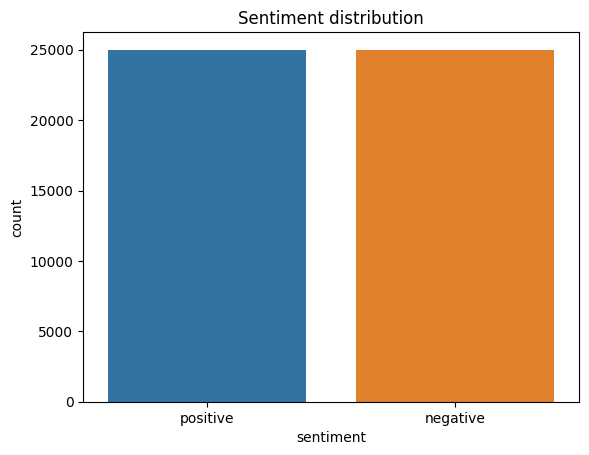

In [1018]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment distribution")
plt.show()

In [1019]:
for _ in range(5):
    i = np.random.randint(0, len(df))
    print("Review: ", [i])
    print(df['review'].iloc[i], "\n")
    print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")

Review:  [3236]
Without question, the worst film I've seen for a long while. I endured to the end because surely there must be something here, but no. The plot, when not dealing in clichés, rambles to the point of non-existence; dialogue that is supposed to be street is simply hackneyed; characters never develop beyond sketches; set-pieces are clichéd. Worse, considering its co-director, the photography is only so-so.<br /><br />Comments elsewhere that elevate this alongside Get Carter, Long Good Friday or Kaspar Hauser are way way off the mark; Lives of the Saints lacks their innovation let alone their depth and shading. In short, their craft. A ruthless editor could probably trim it down to a decent 30-minute short, but as it stands it's a 6th form film project realised on a million-pound scale; rambling and bloated with its own pretensions. That it received funding (surely only because of Rankin's name) while other small films struggle for cash is depressing for the British film ind

In [1020]:
df['word count'] = df['review'].apply(lambda x: len(x.split()))
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


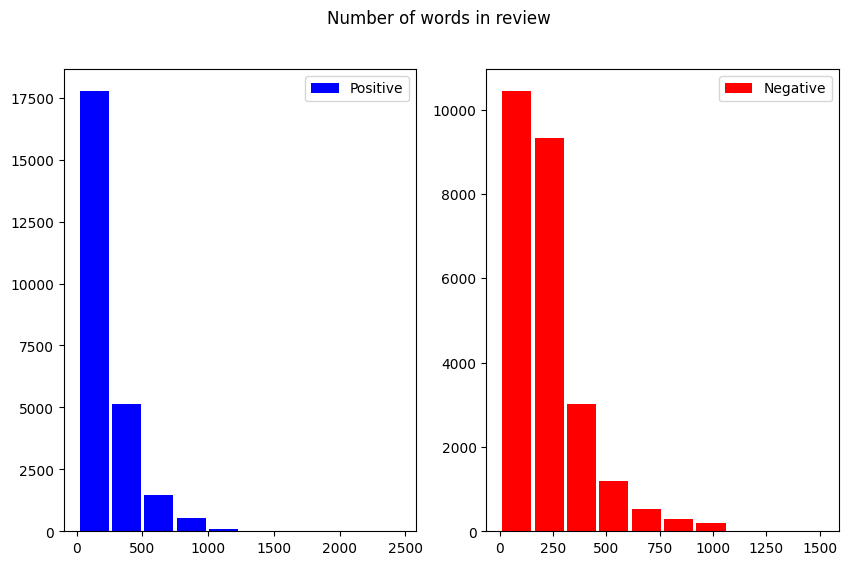

In [1021]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color='blue', rwidth=0.9)
ax[0].legend()
ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='Negative', color='red', rwidth=0.9)
ax[1].legend()
fig.suptitle("Number of words in review")
plt.show()


In [1022]:
df['label'] = df['sentiment'].apply(lambda x: 1 if x == "positive" else 0)
df.head()

,review,sentiment,word count,label
0,One of the other reviewers has mentioned that ...,positive,307,1
1,A wonderful little production. <br /><br />The...,positive,162,1
2,I thought this was a wonderful way to spend ti...,positive,166,1
3,Basically there's a family where a little boy ...,negative,138,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,1


<Figure size 500x800 with 0 Axes>

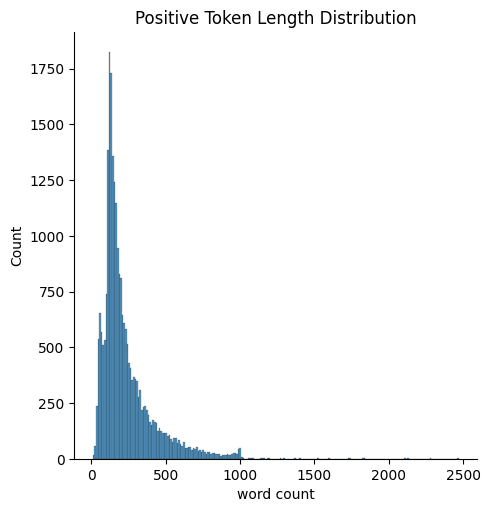

In [1023]:
plt.figure(figsize=(5, 8))
sns.displot(df[df["sentiment"] == "positive"], x='word count')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

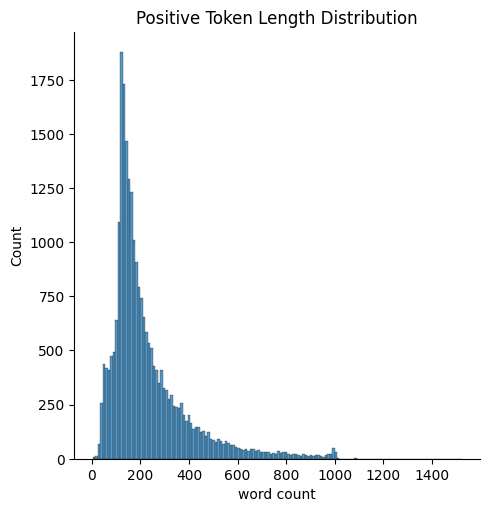

In [1024]:
plt.figure(figsize=(5, 8))
sns.displot(df[df["sentiment"] == "negative"], x='word count')
plt.title('Positive Token Length Distribution')
plt.show()

In [1026]:
def data_processing(text):
    text = text.lower()
    text = re.sub("<br />", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@w+|\#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stopwords]
    return " ".join(filtered_text)


df["review"] = df["review"].apply(data_processing)
df.head()

,review,sentiment,word count,label
0,one reviewers mentioned watching 1 oz episode ...,positive,307,1
1,wonderful little production filming technique ...,positive,162,1
2,thought wonderful way spend time hot summer we...,positive,166,1
3,basically theres family little boy jake thinks...,negative,138,0
4,petter matteis love time money visually stunni...,positive,230,1


In [1027]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)
df = df.drop_duplicates('review')
df.info()

Number of duplicate entries:  421
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49578 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      49578 non-null  object
 1   sentiment   49578 non-null  object
 2   word count  49578 non-null  int64 
 3   label       49578 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.9+ MB


In [1029]:
stemmer = PorterStemmer()
text = []
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data
df["review"] = df['review'].apply(stemming)
df['word count'] = df['review'].apply(lambda x: len(x.split()))
df.head()

,review,sentiment,word count,label
0,one reviewers mentioned watching 1 oz episode ...,positive,168,1
1,wonderful little production filming technique ...,positive,84,1
2,thought wonderful way spend time hot summer we...,positive,86,1
3,basically theres family little boy jake thinks...,negative,67,0
4,petter matteis love time money visually stunni...,positive,125,1


In [1031]:
pos_reviews = df[df["sentiment"] == "positive"]
neg_reviews = df[df["sentiment"] == "negative"]

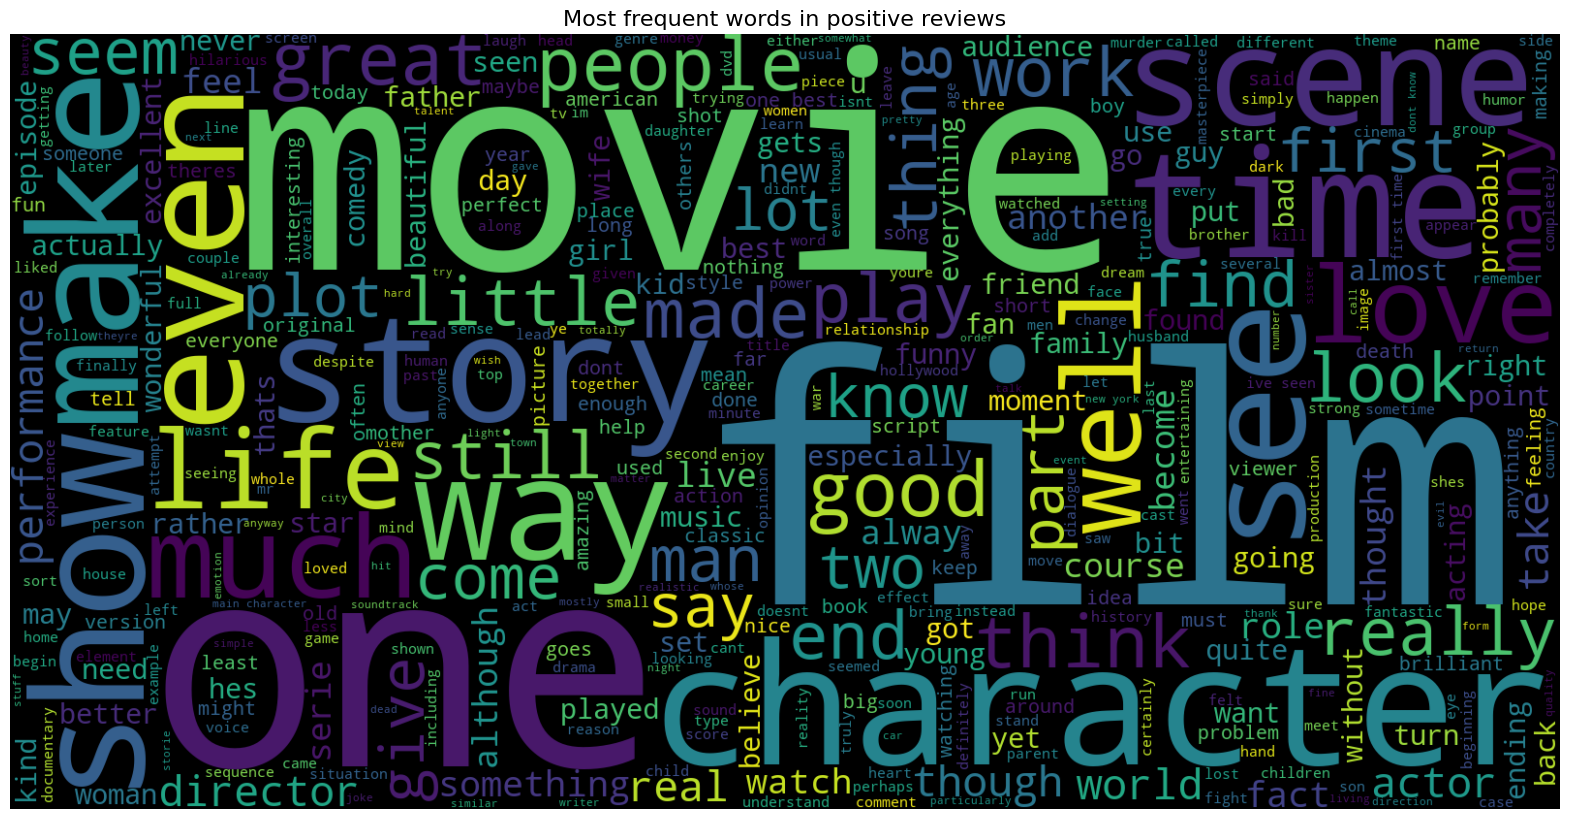

In [1032]:
text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=400, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive reviews', fontsize = 16)
plt.show()

In [1035]:
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] +=1
pos_words = pd.DataFrame(count.most_common(15))
pos_words.columns = ['word', 'count']
pos_words

,word,count
0,film,39285
1,movie,35830
2,one,25621
3,like,16998
4,good,14281
5,great,12568
6,story,12338
7,see,11814
8,time,11724
9,well,10930


In [1036]:
px.bar(pos_words, x='count', y='word', title='Common words in positive reviews', color='word')


NameError: name 'px' is not defined

### TF-IDF
TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate the importance of a word in a document or a corpus of documents. 

The TF part of the formula calculates the frequency of a word in a document. It is calculated by dividing the number of times a word appears in a document by the total number of words in the document. This gives a measure of how often a word appears in a document.

The IDF part of the formula calculates the importance of a word in the corpus. It is calculated by dividing the total number of documents in the corpus by the number of documents that contain the word. This gives a measure of how common or rare a word is in the corpus.

The TF-IDF score is then calculated by multiplying the TF and IDF scores together. This gives a measure of how important a word is in a document, taking into account both its frequency in the document and its rarity in the corpus.

The TF-IDF score is commonly used in information retrieval and text mining applications, such as search engines and document classification. It helps to identify the most relevant documents for a given query by giving higher scores to documents that contain the query terms with high TF-IDF scores.

## 3.2. MLP in torch

In [ ]:
# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

In [ ]:
# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)

# YOUR CODE HERE

raise NotImplementedError()

NotImplementedError: 

In [ ]:
from torch import optim

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=...)

losses = []
criterion = nn.BCELoss()
epochs = ...
for epoch in range(epochs):
    # You can print epoch No. and train/test accuracy here (after each epoch)
    for batch in yourTrainDataloader:
        # do a forward pass on the batch
        # YOUR CODE HERE
        raise NotImplementedError()

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        raise NotImplementedError()

        # zero the gradients
        # YOUR CODE HERE
        raise NotImplementedError()

        # backward pass
        # YOUR CODE HERE
        raise NotImplementedError()

        # gradient step
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
plt.plot(losses)

In [ ]:
# print the classification_report